## This is based on MakeMyPostISRCCDfromRawForSpectractorSD 

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Butler 

In [5]:
import lsst.daf.butler as dafButler

In [6]:
embargo = True

In [7]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

Select collection containing raw data 

In [8]:
collection='LATISS/raw/all'

## Dataframe with the science exposures 

Set up dataframe to store the list of exposures and their information. Select only SCIENCE exposures 

In [9]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'expos','ra','dec','skyangle','science_program'])

In [10]:

#where_exps = "instrument='LATISS' AND exposure.observation_type='science' AND exposure.day_obs={0} AND physical_filter='{1}'".format(exp_date,physical_filter)
where_exps = "instrument='LATISS' AND exposure.observation_type='science'"
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2022091300135
  physical_filter: 'SDSSr~empty'
  obs_id: 'AT_O_20220913_000135'
  exposure_time: 30.0
  dark_time: 30.2355
  observation_type: 'science'
  observation_reason: 'object'
  day_obs: 20220913
  seq_num: 135
  seq_start: 135
  seq_end: 135
  group_name: '2022-09-14T00:03:56.495'
  group_id: 2430434364950000
  target_name: 'SPT-CL-J2040-5725_007'
  science_program: 'AUXTEL_DRP_IMAGING'
  tracking_ra: 310.4110363958637
  tracking_dec: -57.80562480878057
  sky_angle: 359.9975451796987
  azimuth: 153.88579480764747
  zenith_angle: 33.0141217426426
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2022-09-14 00:08:35.295012', scale='tai', format='iso'), end=astropy.time.Time('2022-09-14 00:09:05.531000', scale='tai', format='iso'))
	 timespan:             [2022-09-14T00:08:35.295012, 2022-09-14T00:09:05.531000)
	 timespan.begin:       2022-09-14 00:08:35.295012
	 id:                   2022091300135
	 day_obs:            

In [11]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,expos,ra,dec,skyangle,science_program
20132,2023082900557,AT_O_20230829_000557,20230829,557,2023-08-30 05:38:07.265982,2023-08-30 05:38:27.506,science,HD14943,empty~blue300lpmm_qn1,38.593351,20.0,35.749315,-51.049365,13.295059,spec
20133,2023082900560,AT_O_20230829_000560,20230829,560,2023-08-30 05:39:54.512996,2023-08-30 05:40:24.752,science,HD14943,empty~holo4_003,38.321869,30.0,35.752994,-51.050513,15.740791,spec
20134,2023082900566,AT_O_20230829_000566,20230829,566,2023-08-30 05:44:02.022014,2023-08-30 05:44:22.250,science,HD14943,empty~blue300lpmm_qn1,37.693497,20.0,35.747120,-51.049021,10.738511,spec
20135,2023082900575,AT_O_20230829_000575,20230829,575,2023-08-30 05:49:36.253997,2023-08-30 05:50:06.506,science,HD185975,empty~holo4_003,57.909176,30.0,307.718101,-87.505801,138.116280,spec
20136,2023082900581,AT_O_20230829_000581,20230829,581,2023-08-30 05:53:44.111997,2023-08-30 05:54:24.347,science,HD185975,empty~blue300lpmm_qn1,57.939130,40.0,307.777481,-87.503622,133.113239,spec


In [12]:
len(df_science)

20137

Available sources 

In [13]:
np.unique(np.array(df_science.target.array).astype('str'))

array(['1', '10', '11', '2', '3', '4', '5', '8', '9', 'A2390_001',
       'A2390_008', 'A2390_009', 'A2390_010', 'A2390_015', 'A2390_016',
       'A2390_022', 'A2390_023', 'A2390_024', 'A2390_036', 'A2390_037',
       'A2390_043', 'E5-A_001', 'E5-A_002', 'E5-A_003', 'E5-A_004',
       'E5-A_005', 'E5-A_006', 'E5-A_007', 'E5-A_008', 'E5-A_009',
       'E5-A_010', 'E5-A_011', 'E5-A_012', 'E5-A_013', 'E5-A_014',
       'E5-A_015', 'E5-A_016', 'E5-A_017', 'E5-A_018', 'E5-A_019',
       'E5-A_020', 'E5-A_021', 'E5-A_022', 'E5-A_023', 'E5-A_024',
       'E5-A_025', 'E5-A_026', 'E5-A_027', 'E5-A_028', 'E5-A_029',
       'E5-A_030', 'E5-A_031', 'E5-A_032', 'E5-A_033', 'E5-A_034',
       'E5-A_035', 'E5-A_036', 'E5-A_037', 'E5-A_038', 'E5-A_039',
       'E5-A_040', 'E5-A_041', 'E5-A_042', 'E5-A_043', 'E5-A_044',
       'E5-A_045', 'E5-A_046', 'E5-A_047', 'E5-A_048', 'E5-A_049',
       'E5-A_050', 'E5-A_051', 'E5-A_052', 'E5-A_053', 'E5-A_054',
       'E5-A_055', 'E5-A_056', 'E5-A_057', 'E5-A_05

Available dates 

In [14]:
np.unique(np.array(df_science.day_obs.array))

array([20220912, 20220913, 20220914, 20220927, 20220928, 20220929,
       20221011, 20221012, 20221013, 20221025, 20221026, 20221027,
       20221108, 20221109, 20221110, 20221122, 20221123, 20221124,
       20221207, 20221208, 20221209, 20221210, 20221212, 20230117,
       20230118, 20230119, 20230131, 20230201, 20230202, 20230214,
       20230215, 20230216, 20230228, 20230301, 20230302, 20230314,
       20230315, 20230316, 20230509, 20230510, 20230511, 20230523,
       20230524, 20230525, 20230704, 20230705, 20230706, 20230718,
       20230720, 20230801, 20230802, 20230803, 20230815, 20230816,
       20230817, 20230829])

Available filters 

In [15]:
np.unique(np.array(df_science.filter_disp.array))

array(['BG40_65mm_1~holo4_003', 'BG40~holo4_003', 'BG40~ronchi170lpmm',
       'FELH0600~holo4_003', 'FELH0600~ronchi170lpmm',
       'OG550_65mm_1~holo4_003', 'SDSSg_65mm~empty', 'SDSSi_65mm~empty',
       'SDSSr_65mm~empty', 'SDSSr~empty', 'empty~blue300lpmm_qn1',
       'empty~empty', 'empty~holo4_003', 'empty~ronchi170lpmm',
       'unknown~unknown'], dtype=object)

In [16]:
# set 'all' to select all values 
exp_date = 'all'
physical_filter = 'empty~holo4_003'
source = 'ETA1-DOR'

In [17]:
#df_science[df_science.target==source]
#df_science[(df_science.target==source) & (df_science.day_obs==exp_date)]

In [18]:
if exp_date!='all':
    df_science = df_science[df_science.day_obs==exp_date]
if source!='all':
    df_science = df_science[df_science.target==source]
if physical_filter!='all':
    df_science = df_science[df_science.filter_disp==physical_filter]

In [19]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,expos,ra,dec,skyangle,science_program
14355,2023030100452,AT_O_20230301_000452,20230301,452,2023-03-02 03:29:01.221012,2023-03-02 03:29:31.459,science,ETA1-DOR,empty~holo4_003,46.516058,30.0,91.570264,-66.085830,154.275700,spec
14737,2023030200186,AT_O_20230302_000186,20230302,186,2023-03-03 02:43:20.359999,2023-03-03 02:43:50.606,science,ETA1-DOR,empty~holo4_003,42.853916,30.0,91.651681,-66.073325,142.682226,spec
14738,2023030200187,AT_O_20230302_000187,20230302,187,2023-03-03 02:44:03.528986,2023-03-03 02:44:33.764,science,ETA1-DOR,empty~holo4_003,42.912102,30.0,91.652395,-66.073694,142.681133,spec
14802,2023030200320,AT_O_20230302_000320,20230302,320,2023-03-03 04:40:45.797020,2023-03-03 04:41:16.034,science,ETA1-DOR,empty~holo4_003,53.907003,30.0,91.535183,-66.084961,173.527261,spec
14803,2023030200321,AT_O_20230302_000321,20230302,321,2023-03-03 04:41:28.806000,2023-03-03 04:41:59.035,science,ETA1-DOR,empty~holo4_003,53.979433,30.0,91.535160,-66.084932,173.527141,spec


In [20]:
len(df_science)

168

In [21]:
if exp_date!='all':
    assert df_science.day_obs.unique()[0]==exp_date

In [22]:
if source!='all':
    assert df_science.target.unique()[0]==source

In [23]:
if physical_filter!='all':
    assert df_science.filter_disp.unique()[0]==physical_filter

In [24]:
exposures_selected = []
for index,row in df_science.iterrows():
    #exposure_selected_ = row["day_obs"]*100000+row["seq_num"]
    exposure_selected_ = row["id"]
    #print(exposure_selected_)
    exposures_selected.append(exposure_selected_)
print(exposures_selected)

[2022091400761, 2022091400762, 2022091400782, 2022091400796, 2022091400817, 2022091400839, 2022091400783, 2022091400797, 2022091400818, 2022091400838, 2022091400881, 2022091400859, 2022091400860, 2022091400880, 2022092800635, 2022092800636, 2022092700523, 2022092700535, 2022092700522, 2022092700534, 2022092700558, 2022092700579, 2022092700602, 2022092700557, 2022092700580, 2022092700601, 2022092700669, 2022092700668, 2022092700696, 2022092700695, 2022092700757, 2022092800699, 2022092700756, 2022092700778, 2022092700779, 2022092800579, 2022092800580, 2022092800602, 2022092800700, 2022092800603, 2022092900544, 2022092900545, 2022092900567, 2022092900568, 2022092900633, 2022092900634, 2022092900694, 2022092900693, 2022111000302, 2022111000301, 2022111000346, 2022111000347, 2022111000392, 2022111000408, 2022111000391, 2022111000407, 2022112300310, 2022112300311, 2022112300346, 2022112300347, 2022112300410, 2022112300409, 2022120700386, 2022120700396, 2022120700416, 2022120700387, 202212070

# Retrieve exposures from Butler and make pseudo-postISRCCD 

In [25]:
outdir_base = "./pseudo_postisrccd_img"
if not os.path.exists(outdir_base):
    os.makedirs(outdir_base)
    
outdir_list = []
if exp_date!='all':
    outdir_list.append(exp_date)
else:
    outdir_list.append('all_dates')
if source!='all':
    outdir_list.append(source)
else:
    outdir_list.append('all_sources')
if physical_filter!='all':
    outdir_list.append(physical_filter)
else:
    outdir_list.append('all_phys_filters')

outdir_label = str(outdir_list[0])
for elem_ in outdir_list[1:]:
    outdir_label = outdir_label+'_{0}'.format(elem_.replace('~','-'))

outdir = os.path.join(outdir_base,str(exp_date))
outdir = os.path.join(outdir_base,outdir_label)
if not os.path.exists(outdir):
    os.makedirs(outdir)

## Prepare ISR task and define its inputs with Butler 

In [26]:
# configuration
isr_config =  IsrTaskConfig()

In [27]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [28]:
isr_task = IsrTask(config=isr_config)

Prepare information and collections for calibration 

In [29]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

In [30]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
bias = butler.get('bias',instrument=cameraName,detector=0)
defects = butler.get('defects',instrument=cameraName,detector=0)


In [31]:
show_plot = True

Astropy scale transformations

In [32]:
transform = AsinhStretch() + PercentileInterval(99.)
#transform = PercentileInterval(98.)

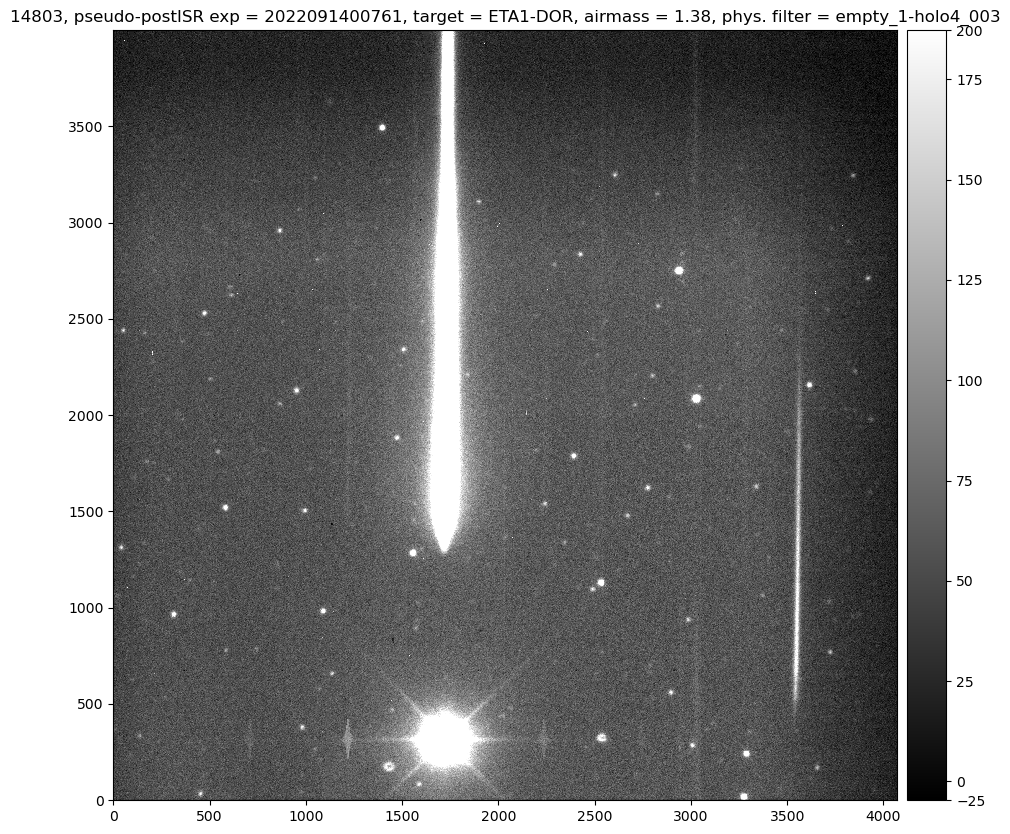

In [33]:
exp_selected_ = exposures_selected[0]

raw_img= butler.get('raw', dataId={'exposure': exp_selected_, 'instrument': 'LATISS', 'detector': 0}, collections = collection)
bias = butler.get("bias",instrument=cameraName, exposure= exp_selected_, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_selected_,detector=0,collections=calibCollections)

meta = raw_img.getMetadata()
md = meta.toDict()

object_ = md['OBJECT']
am_ = md['AMSTART']
filter_ = md['FILTER']
grating_ = md['GRATING']

#fast ISR 
isr_img = isr_task.run(raw_img,bias=bias,defects=defects)

if show_plot:
    %matplotlib inline
    
    rotated_array = isr_img.exposure.image.array[::-1,::-1] #rotate the array 180 degrees
    #np.flip(np.flip(a, 1), 0)


    fig = plt.figure(figsize=(12,10))
    afw_display = afwDisplay.Display(frame=fig)
    afw_display.scale('linear', 'zscale',None)
    the_title = f"{index}, pseudo-postISR exp = {exp_selected_}, target = {object_}, airmass = {am_:.2f}, phys. filter = {filter_}-{grating_}"
    afw_display.mtv(isr_img.exposure.image,title=the_title)

# Save in files

In [35]:
max_files = 10

In [36]:
for exp_selected_ in exposures_selected[:max_files]:
    
    #exposure_selected =row["date"]*100000+row["seq"]
    
    print(f"exposure selected = {exp_selected_}")


    raw_img= butler.get('raw', dataId={'exposure': exp_selected_, 'instrument': 'LATISS', 'detector': 0}, collections = collection)
    bias = butler.get("bias",instrument=cameraName, exposure= exp_selected_, detector=0, collections=calibCollections)
    defects = butler.get('defects',instrument=cameraName, exposure= exp_selected_,detector=0,collections=calibCollections)
    
    
    isr_img = isr_task.run(raw_img,bias=bias,defects=defects)
    
    arr=isr_img.exposure.image.array
    # 180 degree rotation
    rotated_array = arr[::-1,::-1] #rotate the array 180 degrees
    
    
    meta = raw_img.getMetadata()
    md = meta.toDict()

    #object_ = md['OBJECT']
    #am_ = md['AMSTART']
    #filter_ = md['FILTER']

    filename_out = f"exposure_{exp_selected_}_{physical_filter.replace('~','-')}_pseudo-postisrccd.fits"
    fullfilename_out=os.path.join(outdir,filename_out)
    
    print(f">>>>  output filename {filename_out}")
    
    hdr = fits.Header()
    
    for key,value in md.items():
        hdr[str(key)]=value
        
    if hdr['OBJECT']=='MU-COL':
        hdr['OBJECT'] = 'HD38666'
    # need this    
    hdr["AMEND"] = hdr["AMSTART"]
    try: 
        airmass_ = hdr["AIRMASS"]
    except:
        airmass_ = (hdr["AMEND"] + hdr["AMSTART"])/2.
        hdr["AIRMASS"] = airmass_
    
    # be aware weather data may be missing
    if hdr["AIRTEMP"] == None:
        hdr["AIRTEMP"] = 10.0

    if hdr["PRESSURE"] == None:
        hdr["PRESSURE"] = 744.

    if hdr["HUMIDITY"] == None:
        hdr["HUMIDITY"] = 50.

    if hdr["WINDSPD"] == None:
        hdr["WINDSPD"] = 5.

    if hdr["WINDDIR"] == None:
        hdr["WINDDIR"] = 0.   

    if hdr["SEEING"] == None:
        hdr["SEEING"] = 1.15
    
        
   
    
    # Be carefull for Spectractor, 2 hdu units are necessary
    
    primary_hdu = fits.PrimaryHDU(header=hdr)
    image_hdu = fits.ImageHDU(rotated_array)
    #image_hdu = fits.ImageHDU(arr)
    
    hdu_list = fits.HDUList([primary_hdu, image_hdu])
    
    hdu_list.writeto(fullfilename_out,overwrite=True)
    
    
    
    #if exposure_selected not in exposures_sel:
    #    break
    
    #if index>=0:
    #    break
    


exposure selected = 2022091400761


>>>>  output filename exposure_2022091400761_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400762


>>>>  output filename exposure_2022091400762_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400782


>>>>  output filename exposure_2022091400782_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400796


>>>>  output filename exposure_2022091400796_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400817


>>>>  output filename exposure_2022091400817_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400839


>>>>  output filename exposure_2022091400839_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400783


>>>>  output filename exposure_2022091400783_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400797


>>>>  output filename exposure_2022091400797_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400818


>>>>  output filename exposure_2022091400818_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400838


>>>>  output filename exposure_2022091400838_empty-holo4_003_pseudo-postisrccd.fits


## Check that the images were correctly saved 

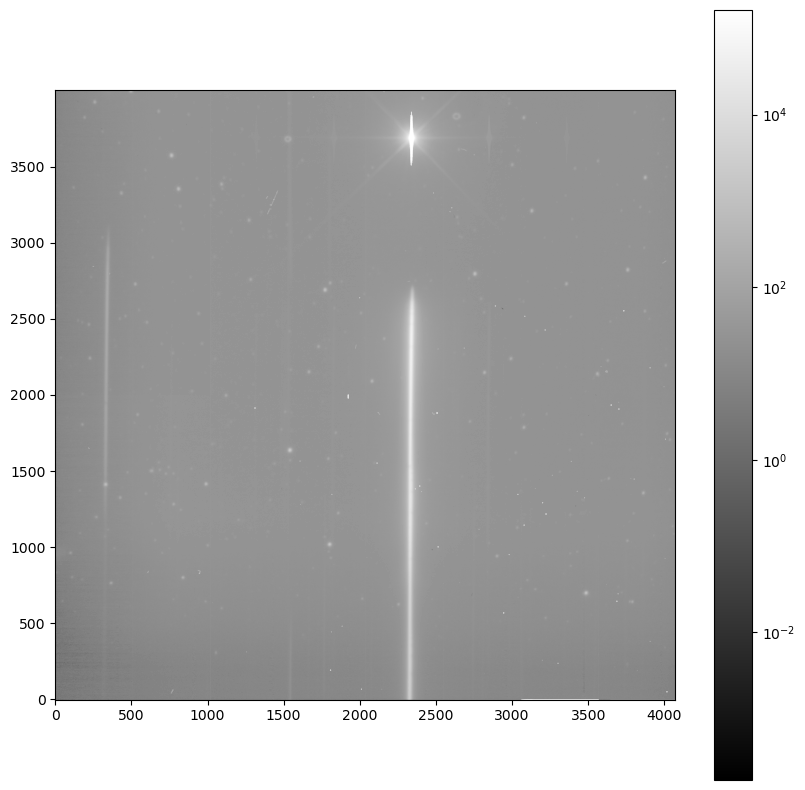

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(rotated_array,cmap="gray",origin='lower',norm=LogNorm())
plt.colorbar(im,ax=ax)

## Now we look for the flats taken on the closest date to that of the selected exposure 

In [38]:
#calibCollections = ['LATISS/defaults','LATISS/raw/all']
#for col in registry.queryCollections("*LATISS/calib*"):
#    print(col)
#    calibCollections.append(col)
#calibCollections = ...

In [39]:
where_flats = "instrument='LATISS' AND physical_filter='empty~empty' AND exposure.observation_type='flat'"

In [40]:
flats_records = list(registry.queryDimensionRecords('exposure',where=where_flats))

In [51]:
#flats_records

In [42]:
print(len(flats_records))
assert len(flats_records)!=0

666


In [43]:
flats_records[0].id

2022091200073

In [44]:
flat_year = '2023'

In [45]:
flat_dates = []
for flat_ in flats_records:
    if flat_year in str(flat_.day_obs):
        flat_dates.append(flat_.day_obs)


In [46]:
flat_dates = np.unique(flat_dates)
print(flat_dates)

[20230112 20230116 20230118 20230214 20230321 20230327 20230404 20230420
 20230425 20230509 20230510 20230523 20230524 20230525 20230705 20230706
 20230724 20230725 20230726 20230727 20230801 20230802 20230803 20230811
 20230816 20230817 20230823 20230829 20230830]


In [47]:
flat_date = 20230116

In [48]:
flats_selected = []
for flat_ in flats_records:
    if flat_.day_obs==flat_date:
        flats_selected.append(flat_.id)
print(flats_selected)

[2023011600015, 2023011600014, 2023011600016]


Check that we can load the flats 

In [49]:
flat_arrays = []
for fid_ in flats_selected:
    flat_img = butler.get(
        "flat",
        instrument="LATISS", exposure=fid_, detector=0,
        collections=calibCollections)
    flat_arrays.append(flat_img.getImage().array)